# Predicting Electronic density of states N(E$_f$) Refractory High-Entropy Alloys using Machine Learning

In our recent studies, ( _https://doi.org/10.1016/j.matdes.2025.113885_, `Materials & Design, 2025`), the electronic density of states at the Fermi level (**N(E$_f$)**) has emerged as a powerful descriptor for predicting key mechanical properties of refractory high entropy alloys (RHEAs), such as **elastic modulus, bond stiffness, ductility**, and **local lattice distortion (LLD)**. However, calculating NN(E$_f$) typically requires expensive DFT simulations. In this notebook, we build a machine learning model that predicts N(Ef) directly from alloy composition, eliminating the need for computationally expensive electronic structure calculations. This capability enables rapid screening and design of new RHEAs with optimized properties, making the approach both time-efficient and impactful for accelerating materials discovery.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import math
%matplotlib inline

In [2]:
df = pd.read_excel('all_data_combined_ml_dos_enthaly_structure.xlsx')
df.head()

,Alloy,N(Ef),DH (eV),Structure
0,Cr100,0.6025,0.0,BCC
1,Mo100,0.5635,0.0,BCC
2,W100,0.4296,0.0,BCC
3,V100,1.9982,0.0,BCC
4,Nb100,1.8519,0.0,BCC


- The electronic density of states at the Fermi level (**N(E$_f$)**) is obtianed from first principle density functional theory calcualtions.
- The enthalpy change (DH) is calculated using the formula:

$$
\Delta H = E(\text{alloy}) - \sum E(\text{pure elements})
$$

#### Explanation

1. **E(alloy)**:
   - Represents the total energy of the alloy.
   - This value is typically negative.

2. **∑E(pure elements)**:
   - Represents the sum of the energies of the pure elements.
   - These values are also negative and stored in the `H_purSince both **E(alloy)** and **∑E(pure elements)** are negative, the subtraction reflects the relative stability of the alloy compared to its constituent pure elements.ent pure elements.
nt pure elements.


In [3]:
# Check duplicate alloys
duplicate_alloys = df[df['Alloy'].duplicated(keep=False)]

# Print duplicate alloy names
print("Number of duplicate alloy names:", duplicate_alloys.shape[0])
print("\nDuplicate alloy names:")
print(duplicate_alloys)

Number of duplicate alloy names: 0

Duplicate alloy names:
Empty DataFrame
Columns: [Alloy, N(Ef), DH (eV), Structure]
Index: []


 ## Feature Engineering

## Creating Composition-Based Features
In this section, we generate several important chemical and thermodynamic features directly from the alloy compositions. These features serve as the input to our machine learning model, allowing us to predict Young’s modulus without relying on expensive DFT calculations.

We import custom feature-engineering functions from ML_functions.ipynb and apply them to each alloy:

## Elemental Percentages:
Extracts and adds individual elemental fractions as separate features. Serve as baseline compositional descriptors to capture the influence of individual elements.

These composition-based features form the foundation for training our ML model to predict elastic properties.

## Mixing Enthalpy:

Mixing Enthalpy Captures the energy change due to element interactions during alloy formation and influences phase stability and bond strength.

The mixing enthalpy is calculated using the following formula:
  $$
  \Delta H_{\text{mix}} = \sum_{i=1, i \neq j}^{n} 4H_{ij}C_iC_j
  $$
  where:
  - $C_i, C_j$: Molar percentages of elements $i$ and $j$.
  - $H_{ij}$: Interaction parameter (enthalpy of mixing) for the element pair $i$ and $j$.

- Iterates through all unique pairs of elements and calculates the contribution to the total enthalpy of mixing.

- 

## Valence Electron Concentration (VEC):
VEC is a key predictor of phase stability and mechanical properties. Strongly correlated with the phase type (e.g., BCC, FCC) and key mechanical properties like stiffness and ductility.

The Valence Electron Concentration (VEC) is calculated using the following formula:

$$
\text{VEC} = \sum_{i=1}^{n} C_i \cdot \text{VEC}_i
$$

Where:

- **$C_i$**: Atomic (molar) percentage of element $i$ in the alloy, normalized such that $\sum C_i = 1$ (or divided by 100 if input is in %)
- **$\text{VEC}_i$**: Valence electron count of element $i$
- **$n$**: Total number of elements in the alloy

This weighted average gives a single scalar value that reflects the average number of valence electrons per atom in the alloy — a useful descriptor for predicting phase stability and mechanical properties.

## Melting Temperature (MT)

The melting temperature is calculated as a weighted average of the constituent elements' melting points, serving as an indicator of thermal stability and bonding characteristics.

Melting Temperature (MT) is calculated using the following formula:

$$
\text{MT} = \frac{\sum_{i=1}^{n} C_i \cdot T_i}{100}
$$

**Parameters:**
- $C_i$: Atomic percentage of element $i$ (0-100%)
- $T_i$: Melting point of element $i$ (in Kelvin)
- $n$: Number of elements in the alloy


## Pauling electronegativity: 
It is an averageselectronegativity difference among alloying elements. Differences in electronegativity between elements affect charge transfer and bond character.

Pauling Electronegativity is calculated using the following formula:

$$
\chi = \frac{\sum_{i=1}^{n} (C_i \cdot \chi_i)}{100}
$$

Where:
- $\chi_i$ = Pauling electronegativity of element $i$  
- $C_i$ = Atomic percentage of element $i$  
- $n$ = Number of elements in the alloy

Components:
1. The sum ($\sum$) runs over all elements ($i = 1$ to $n$)
2. Each element's contribution is its percentage ($C_i$) multiplied by its electronegativity ($\chi_i$)
3. The total is divided by 100 to convert from percentage to fraction

## Entropy of Mixing:
Configurational entropy assuming ideal mixing. Represents the configurational randomness in the alloy and plays a crucial role in stabilizing single-phase solid solutions.

Entropy of Mixing (ΔS<sub>mix</sub>) is calculated using the following formula:

$$
\Delta S_{mix} = -R \sum_{i=1}^{n} (x_i \cdot \ln x_i)
$$

 Where:
- $R$ = Gas constant (8.314 J/mol·K)
- $x_i$ = Molar fraction of element $i$ ($x_i = C_i/100$)
- $n$ = Number of elements in the alloy

**Key Points:**
- The natural log (ln) requires $x_i > 0$
- Summation runs over all elements in the alloy
- Negative sign ensures positive entropy for mixing
- Units: Joules per mole-Kelvin (J/mol·K)


## Radii difference (δ)

The atomic size difference (δ) is calculated using the following formula:

$$
\delta = \sum_{i=1}^{n} C_i \left( 1 - \frac{r_i}{\bar{r}} \right)^2
$$

where:
- $C_i$ is the atomic percentage of element $i$,
- $r_i$ is the atomic radius of element $i$,
- $\bar{r}$ is the average atomic radius of the alloy.

## Importing Feature Engineering Functions
In this section, we import custom functions to generate important chemical descriptors for a given alloy composition. These functions are defined in a separate notebook, ML_functions.ipynb, which we import using Jupyter’s %run command. We will also verify a few computed properties to ensure the feature generation is working as expected.

In [4]:
%run ML_functions.ipynb

Import Successful!


In [5]:
## TEST imported functions
composition = 'W20Nb20Mo20Ta20V20'

# Calculate mixing enthalpy
mixing_enthalpy = calculate_mixing_enthalpy(composition, AB_mix_enthalpy)
print(f"Mixing Enthalpy: {mixing_enthalpy} kJ/mol")

Mixing Enthalpy: -4.640000000000001 kJ/mol


In [6]:
## TEST imported functions
composition = "Ta20Nb20Hf20Zr20Ti20"
delta = calculate_atomic_size_difference(composition, metallic_radius)
print(f"Atomic size difference (δ) for {composition}: {delta:.4f}")

Atomic size difference (δ) for Ta20Nb20Hf20Zr20Ti20: 0.4267


In [7]:
# Using imported functions to create new features

# Mixing enthalpy
df['Mixing Enthalpy'] = df['Alloy'].apply(lambda x: calculate_mixing_enthalpy(x, AB_mix_enthalpy))

# VEC
df['VEC'] = df['Alloy'].apply(lambda x: calculate_vec(x, pvec))

# Melting temperature
df['Melting Temperature'] = df['Alloy'].apply(lambda x: calculate_mt(x, mt))

# Electronegativity
df['Pauling Electronegativity'] = df['Alloy'].apply(lambda x: calculate_pauli(x, chi))

# Entropy of mixing
df['Entropy of Mixing'] = df['Alloy'].apply(calculate_entropy_of_mixing)

df['Radii Difference'] =df['Alloy'].apply(lambda x: calculate_atomic_size_difference(x, metallic_radius))

# Apply the function and expand the result into new columns
percentages_df = df['Alloy'].apply(lambda x: calculate_element_percentages(x)).apply(pd.Series)
df = pd.concat([df, percentages_df], axis=1)

In [8]:
df.head()

,Alloy,N(Ef),DH (eV),Structure,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Radii Difference,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf
0,Cr100,0.6025,0.0,BCC,0.0,6.0,1907.0,1.66,-0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Mo100,0.5635,0.0,BCC,0.0,6.0,2623.0,2.16,-0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,W100,0.4296,0.0,BCC,0.0,6.0,3422.0,2.36,-0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
3,V100,1.9982,0.0,BCC,0.0,5.0,1910.0,1.63,-0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
4,Nb100,1.8519,0.0,BCC,0.0,5.0,2477.0,1.60,-0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


In [9]:
df.columns

Index(['Alloy', 'N(Ef)', 'DH (eV)', 'Structure', 'Mixing Enthalpy', 'VEC',
       'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing',
       'Radii Difference', 'Cr', 'Mo', 'W', 'V', 'Nb', 'Ta', 'Ti', 'Zr', 'Hf'],
      dtype='object')

In [10]:
df.shape

(460, 19)

In [12]:
# Select only BCC structures
df= df[df['Structure']=='BCC']

df.head()

,Alloy,N(Ef),DH (eV),Structure,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Radii Difference,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf
0,Cr100,0.6025,0.0,BCC,0.0,6.0,1907.0,1.66,-0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Mo100,0.5635,0.0,BCC,0.0,6.0,2623.0,2.16,-0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,W100,0.4296,0.0,BCC,0.0,6.0,3422.0,2.36,-0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
3,V100,1.9982,0.0,BCC,0.0,5.0,1910.0,1.63,-0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
4,Nb100,1.8519,0.0,BCC,0.0,5.0,2477.0,1.60,-0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


In [13]:
df.shape

(414, 19)

In [14]:
df.to_csv('final_df_all_bcc.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 414 entries, 0 to 459
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Alloy                      414 non-null    object 
 1   N(Ef)                      414 non-null    float64
 2   DH (eV)                    414 non-null    float64
 3   Structure                  414 non-null    object 
 4   Mixing Enthalpy            414 non-null    float64
 5   VEC                        414 non-null    float64
 6   Melting Temperature        414 non-null    float64
 7   Pauling Electronegativity  414 non-null    float64
 8   Entropy of Mixing          414 non-null    float64
 9   Radii Difference           414 non-null    float64
 10  Cr                         414 non-null    float64
 11  Mo                         414 non-null    float64
 12  W                          414 non-null    float64
 13  V                          414 non-null    float64
 14 

In [15]:
## No null values above !!

In [16]:
feature_columns =['Mixing Enthalpy', 'VEC', 'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing', 'Radii Difference',
                  'Cr', 'Mo', 'W', 'V', 'Nb', 'Ta', 'Ti', 'Zr', 'Hf' ] 

X=df[feature_columns]
y=df['N(Ef)']

## Data analysis

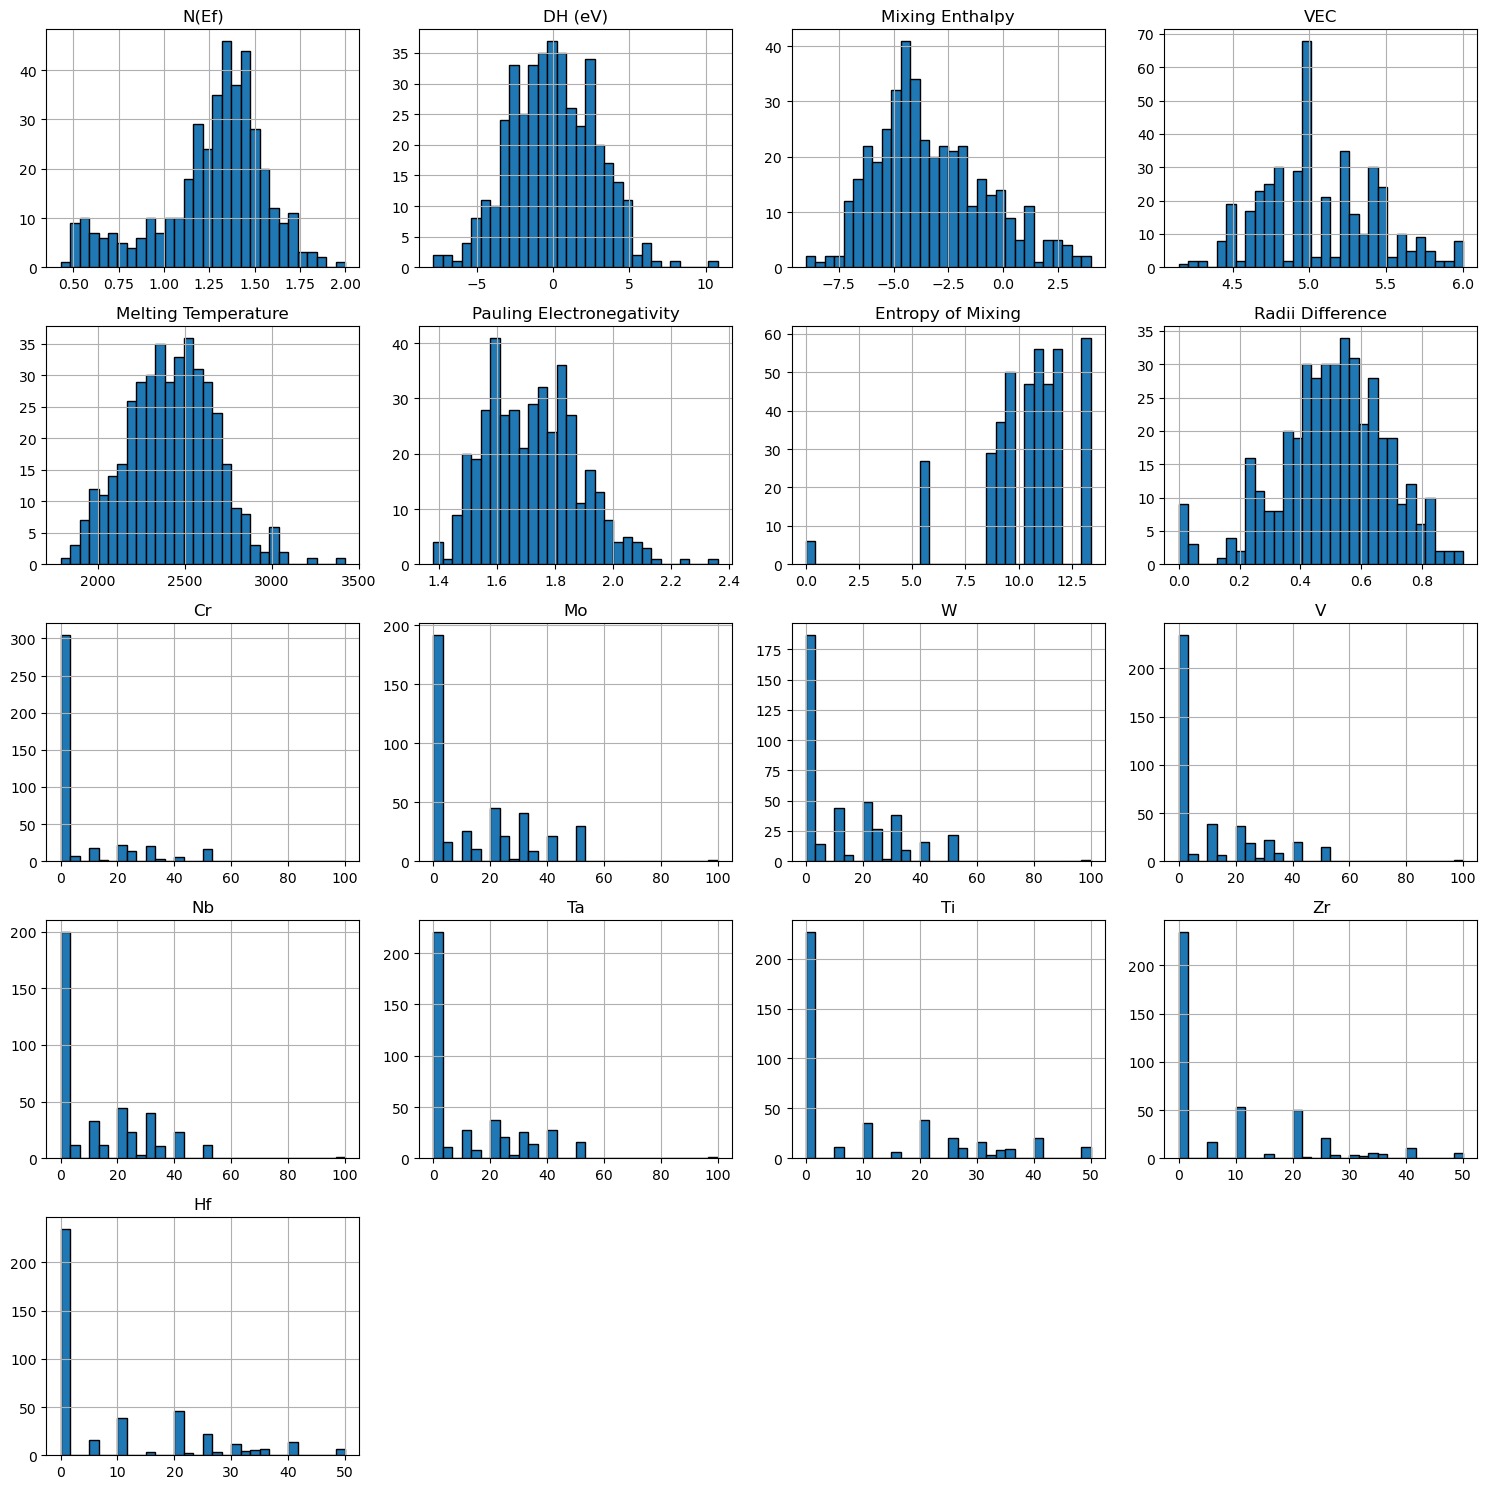

In [17]:
# plot histogram of each feature
df.hist(figsize = (15, 15), bins= 30, edgecolor = 'black')
plt.tight_layout()
plt.show()

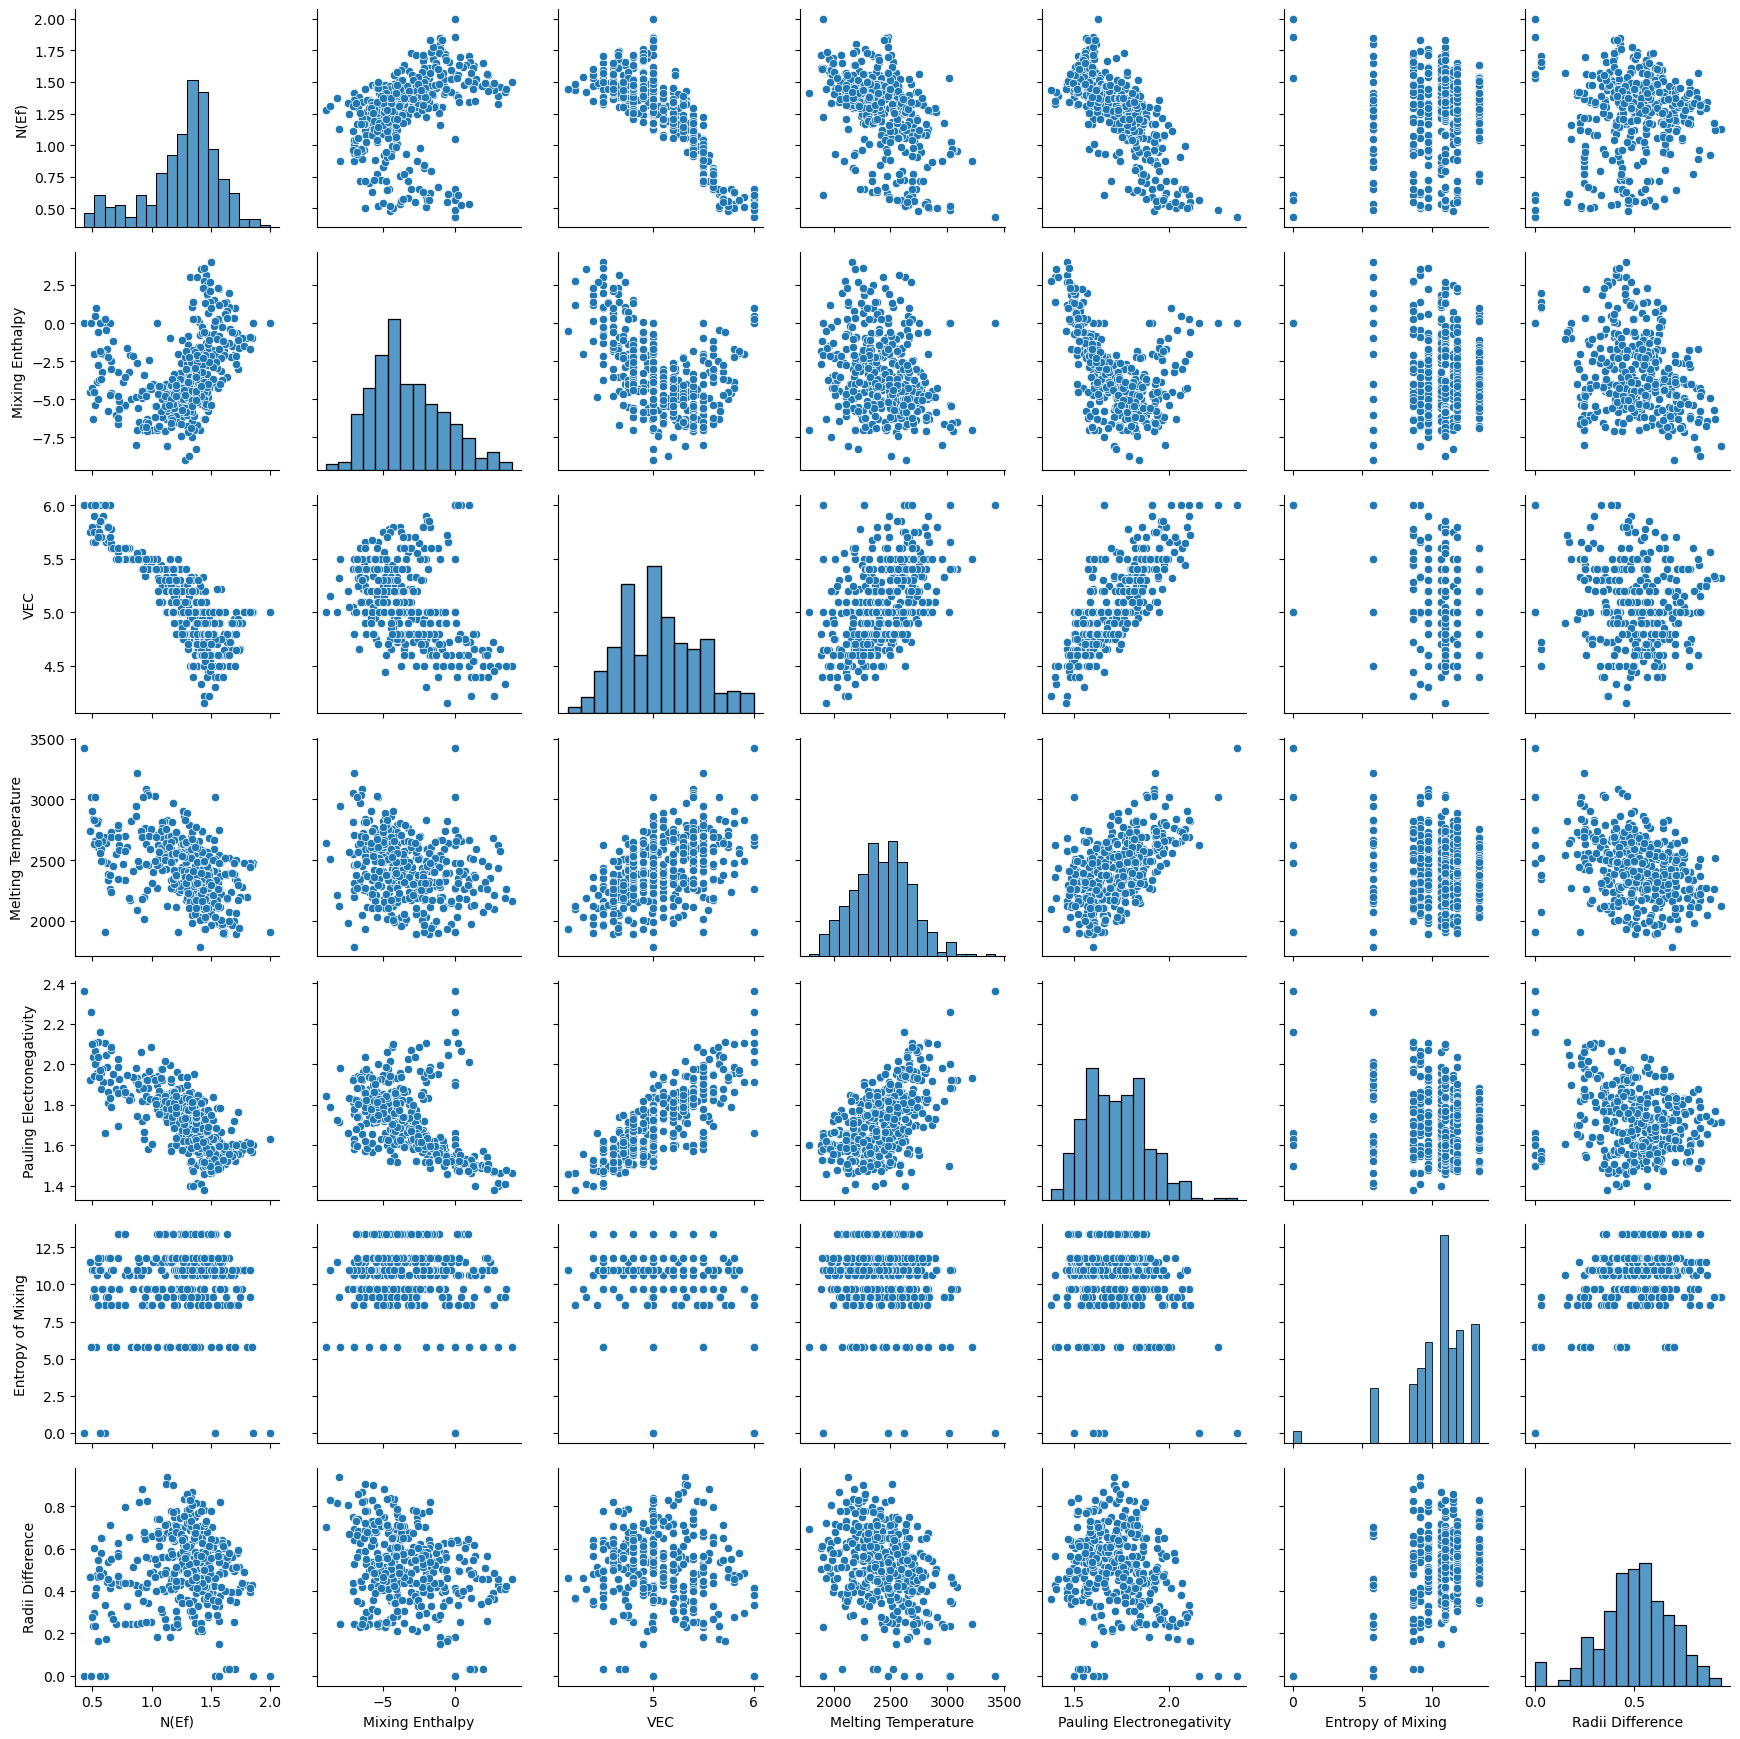

In [18]:
# plt.figure(figsize=(8,8))
sns.pairplot(df[['N(Ef)','Mixing Enthalpy', 'VEC', 'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing', 'Radii Difference']])  # Creates scatter plots for all pairs of features
plt.tight_layout()
plt.show()

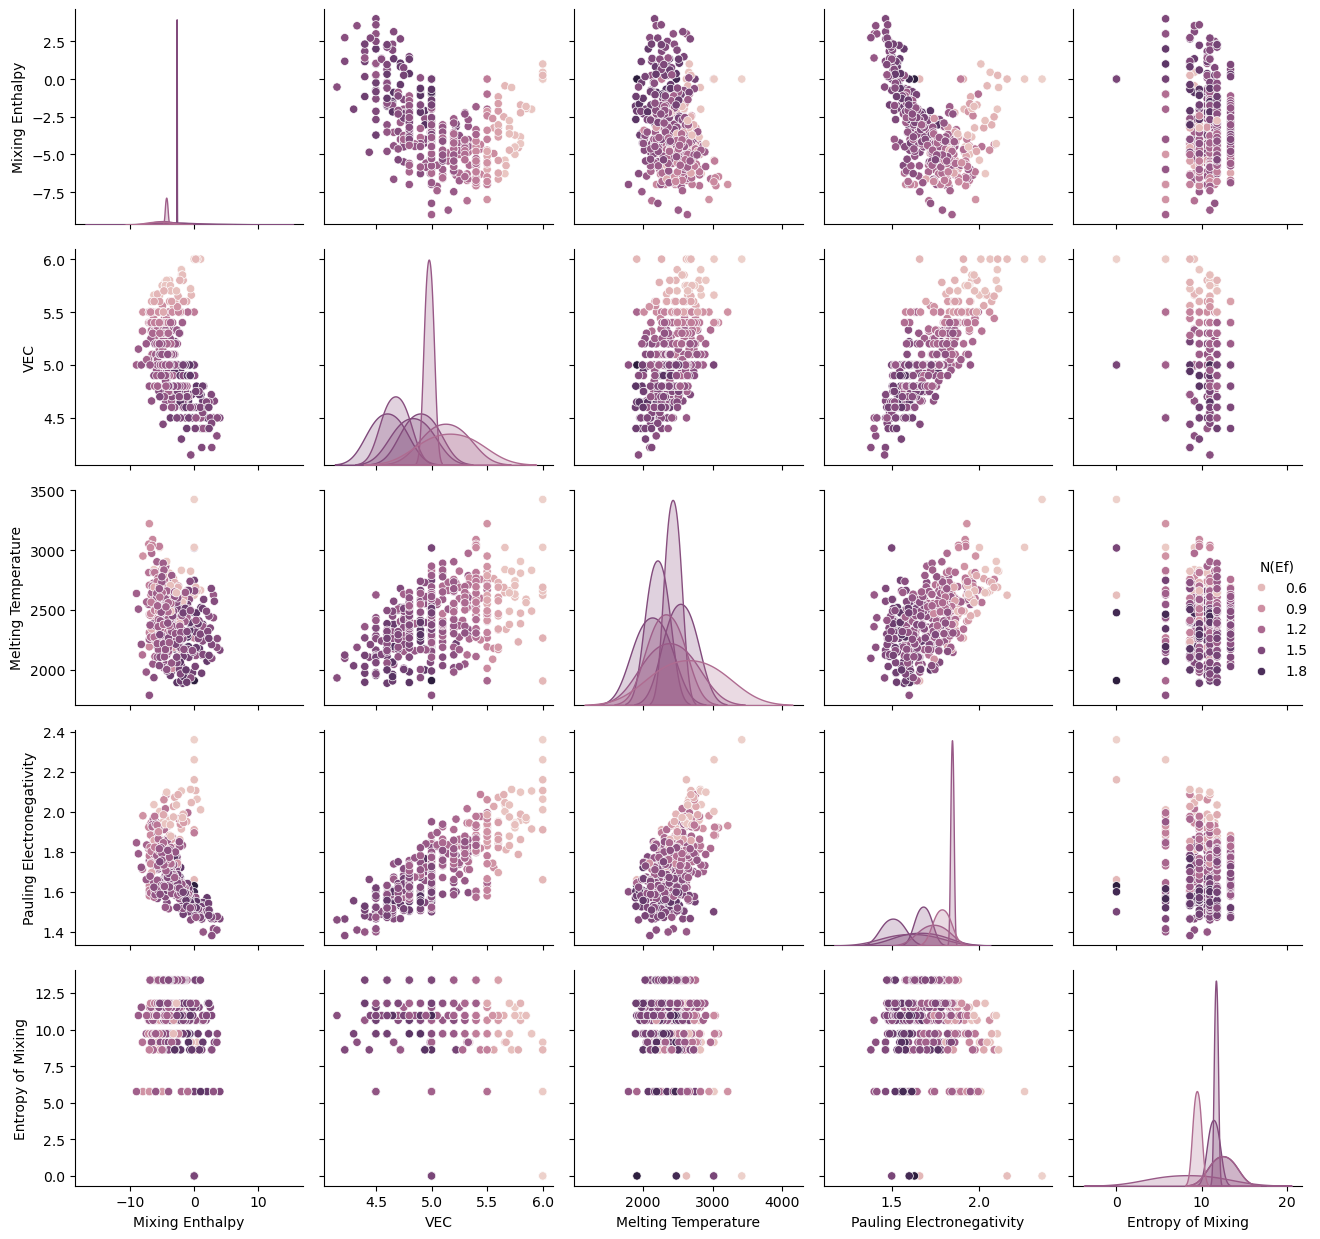

In [19]:
sns.pairplot(df[['N(Ef)','Mixing Enthalpy', 'VEC', 'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing']], hue='N(Ef)')  # Replace 'target_column' with the name of your categorical column
plt.tight_layout()
plt.show()

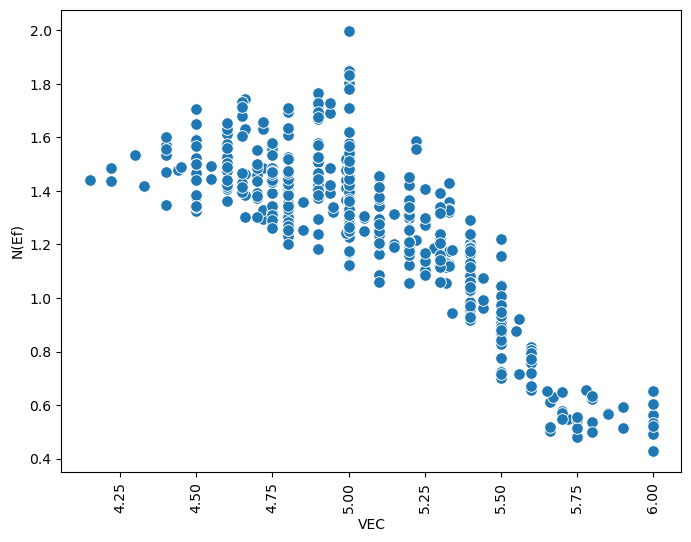

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='VEC', y='N(Ef)', data=df, s=70)
plt.xticks(rotation =90)
r = np.corrcoef( df['VEC'], df['N(Ef)'])[0, 1]
# plt.text(4, 2.25, f'Pearson correlation coefficient (r): {r:.2f}')
plt.show()

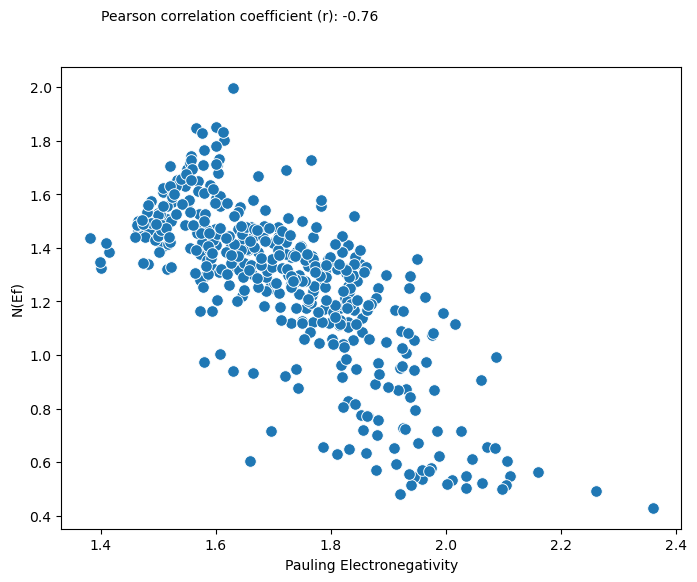

In [21]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Pauling Electronegativity', y='N(Ef)', data=df, s=70)
r = np.corrcoef( df['Pauling Electronegativity'], df['N(Ef)'])[0, 1]
plt.text(1.4, 2.25, f'Pearson correlation coefficient (r): {r:.2f}')

plt.xticks()
plt.show()


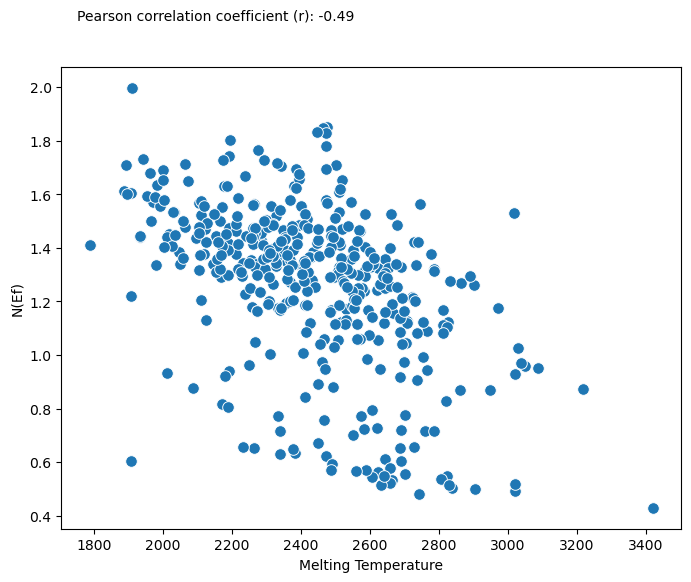

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Melting Temperature', y='N(Ef)', data=df, s=70)
r = np.corrcoef( df['Melting Temperature'], df['N(Ef)'])[0, 1]
plt.text(1750, 2.25, f'Pearson correlation coefficient (r): {r:.2f}')

plt.xticks()
plt.show()


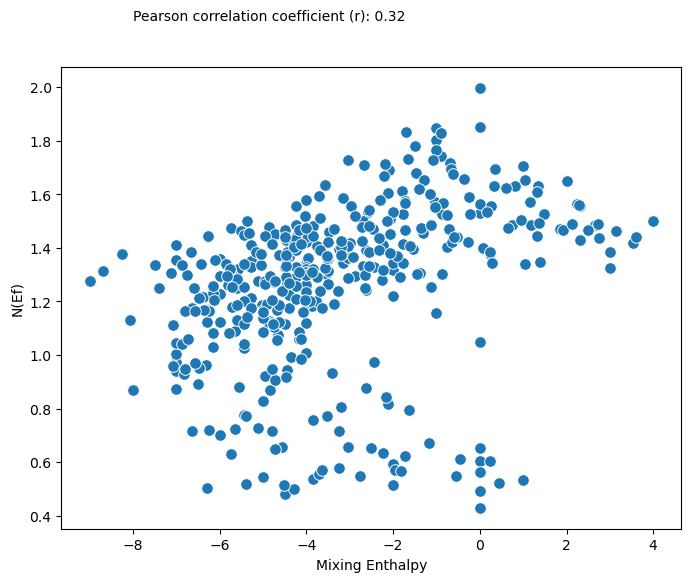

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Mixing Enthalpy', y='N(Ef)', data=df, s=70)
r = np.corrcoef( df['Mixing Enthalpy'], df['N(Ef)'])[0, 1]
plt.text(-8, 2.25, f'Pearson correlation coefficient (r): {r:.2f}')

plt.xticks()
plt.show()


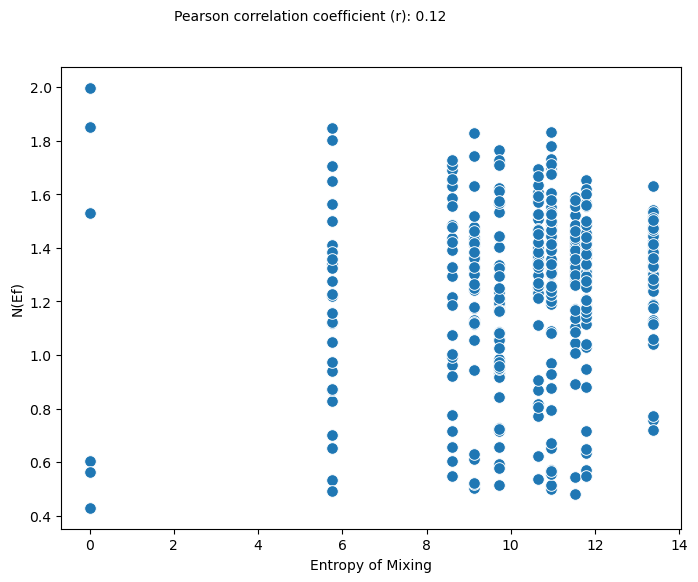

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Entropy of Mixing', y='N(Ef)', data=df, s=70)
r = np.corrcoef( df['Entropy of Mixing'], df['N(Ef)'])[0, 1]
plt.text(2, 2.25, f'Pearson correlation coefficient (r): {r:.2f}')

plt.xticks()
plt.show()

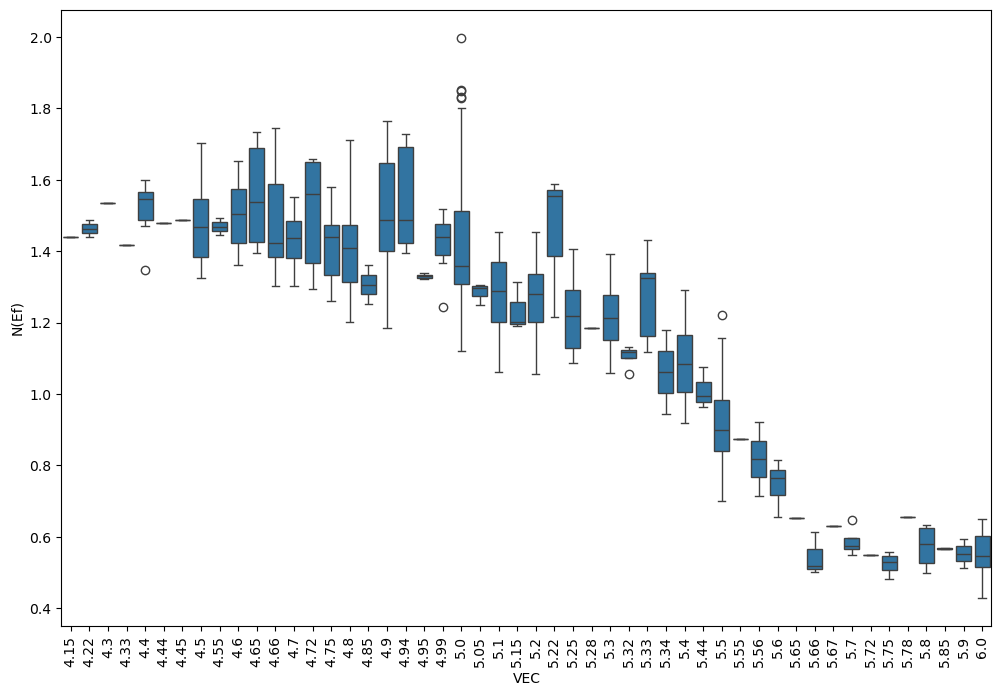

In [25]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='VEC', y='N(Ef)', data=df)
plt.xticks(rotation =90)
plt.show()


Even when VEC is fixed, N(E<sub>f</sub>) varies significantly due to differences in alloy chemistry and bonding. This reinforces that N(E<sub>f</sub>), which capture all electronic interactions, is a more precise and sensitive descriptor for understanding and predicting alloy behavior than VEC alone.

The points flagged as "outliers" by the boxplot are not necessarily errors in materials science. In fact, they may reveal chemically or electronically unique alloy configurations. Rather than discarding them, they should be examined more closely—they might hold the key to discovering non-intuitive behavior or novel materials.

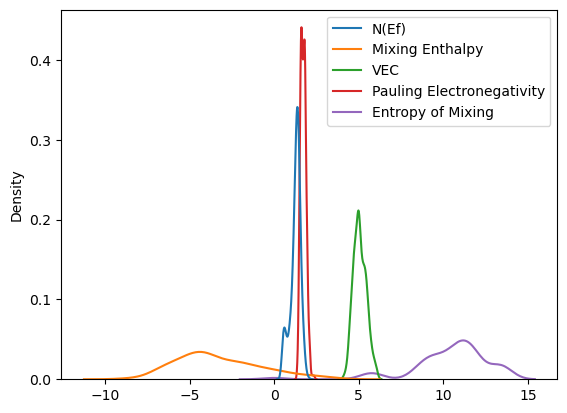

In [26]:
sns.kdeplot(data =df[['N(Ef)','Mixing Enthalpy', 'VEC',  'Pauling Electronegativity', 'Entropy of Mixing']])
plt.show()

The KDE plot above shows the distribution of key descriptors for refractory alloys: N(Ef), Mixing Enthalpy, Valence Electron Concentration (VEC), Pauling Electronegativity, and Entropy of Mixing. N(Ef), VEC, and Electronegativity display narrow, sharp peaks, indicating limited variation across the refractory alloy dataset, likely due to the similar electronic structure and valence configuration of refractory elements. In contrast, Mixing Enthalpy and Entropy of Mixing exhibit broader distributions, reflecting greater diversity in atomic interactions and compositional complexity. These trends highlight that while electronic descriptors remain relatively stable in refractory systems, thermodynamic properties introduce more variation and may better capture differences in alloy behavior.

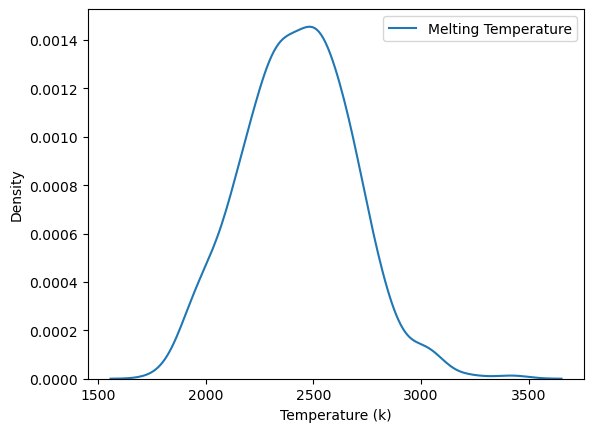

In [27]:
sns.kdeplot(data =df[['Melting Temperature']])
plt.xlabel( 'Temperature (k)')
plt.show()

The KDE plot above shows the distribution of melting temperatures for a set of refractory alloys. The curve peaks around 2400–2500 K, indicating that most alloys in the dataset have melting temperatures in this range. The distribution is moderately skewed to the right, with a long tail extending beyond 3000 K, reflecting the presence of a few ultra-high-temperature alloys. This trend is consistent with the high thermal stability characteristic of refractory materials, which typically include elements like Mo, W, Ta, and Nb. The overall spread suggests a broad design space in terms of thermal resistance within the studied alloys.

## Correlations between the input features: Heatmap matix

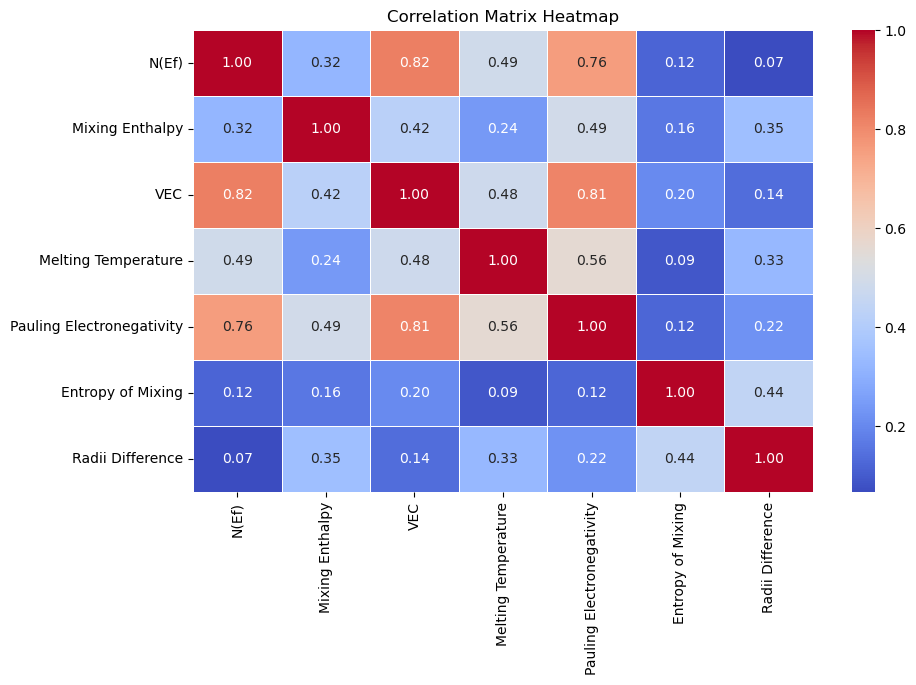

In [28]:
cor_feature =['N(Ef)','Mixing Enthalpy', 'VEC', 'Melting Temperature', 'Pauling Electronegativity', 'Entropy of Mixing', 'Radii Difference']
Cr = df[cor_feature]
plt.figure(figsize=(10,6))
sns.heatmap(Cr.corr().abs(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()
          

**Note:** Some of the input features in this dataset are highly correlated. While multicollinearity can be problematic for linear models by inflating coefficient variance, it is less of a concern for **tree-based models**, which are generally robust to redundant features. In the case of linear models, techniques like **Ridge regression** (L2 regularization) and **Lasso regression** (L1 regularization) can be used to mitigate this issue by penalizing large coefficients and performing feature selection. In this project, we will monitor model performance closely and apply appropriate regularization or feature selection techniques as needed to ensure both accuracy and stability.

### Rule of mixture Young's Modulus (E_VRH)
While we are not using Young's modulus as a training feature—since our objective is to predict N(E$_f$) from chemical composition—we include it here to explore its correlation with other features.

In [29]:

# Define the Young’s modulus (E_VRH) dictionary
evrh = {
    "Cr": 279, "Mo": 329, "W": 382, "V": 130, "Nb": 105, "Ta": 186, 
    "Ti": 116, "Hf": 78, "Zr": 88, "Re": 450, "Ru": 480
}


def calculate_weighted_evrh(composition, evrh):
    """
    Calculate the weighted average Young’s modulus (E_VRH) for the alloy.

    Args:
        composition (str): The alloy composition.
        evrh (dict): A dictionary of E_VRH values for each element.

    Returns:
        float: Weighted average Young’s modulus (E_VRH).
    """
    percentages = parse_atomic_percentages(composition)

    # Compute weighted Young’s modulus
    evrh_sum = sum(percentage * evrh.get(element, 0) for element, percentage in percentages.items())
    return evrh_sum / 100  # Normalize by 100

# Calculate only E_VRH for each alloy
df['Avg E'] = df['Alloy'].apply(lambda x: calculate_weighted_evrh(x, evrh))
df.head()

,Alloy,N(Ef),DH (eV),Structure,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Radii Difference,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf,Avg E
0,Cr100,0.6025,0.0,BCC,0.0,6.0,1907.0,1.66,-0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,279.0
1,Mo100,0.5635,0.0,BCC,0.0,6.0,2623.0,2.16,-0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,329.0
2,W100,0.4296,0.0,BCC,0.0,6.0,3422.0,2.36,-0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,382.0
3,V100,1.9982,0.0,BCC,0.0,5.0,1910.0,1.63,-0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,130.0
4,Nb100,1.8519,0.0,BCC,0.0,5.0,2477.0,1.60,-0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,105.0


In [30]:
df.shape

(414, 20)

## Correlation between N(Ef) and 'Mixing Enthalpy

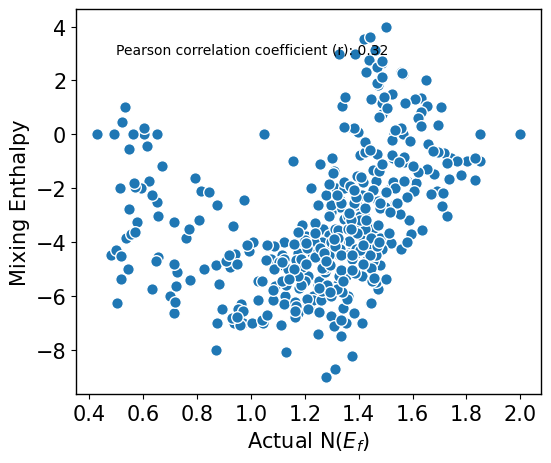

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
fs = 15
plt.scatter(df['N(Ef)'], df['Mixing Enthalpy'], marker='o', c= 'tab:blue', s=70, edgecolor='w')
plt.xlabel(r'Actual N($E_f$)', fontsize=fs)
plt.ylabel('Mixing Enthalpy', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

# Calculate Pearson correlation coefficient

r = np.corrcoef(df['N(Ef)'], df['Mixing Enthalpy'])[0, 1]
# print("Pearson correlation coefficient (r):", r)

# Adjusting spine linewidth
sp=1
ax = plt.gca()
ax.spines['top'].set_linewidth(sp)
ax.spines['right'].set_linewidth(sp)
ax.spines['left'].set_linewidth(sp)
ax.spines['bottom'].set_linewidth(sp)
plt.text(0.5, 3, f'Pearson correlation coefficient (r): {r:.2f}')
plt.show()


This trend suggests a potential correlation between electronic structure and thermodynamic stability—higher N(E<sub>f</sub>) values may be associated with weaker bonding (hence less negative mixing enthalpy), while lower N(E<sub>f</sub>) alloys may exhibit stronger interactions and more stable mixing. However, the spread in the data also highlights the influence of other factors such as atomic size mismatch or entropic contributions.

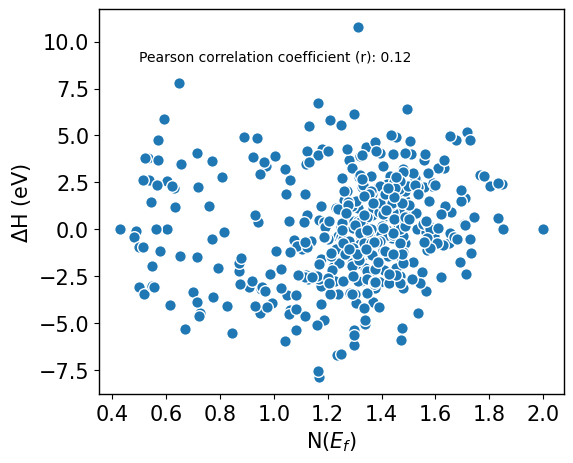

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
fs = 15
plt.scatter(df['N(Ef)'], df['DH (eV)'], marker='o', c= 'tab:blue', s=70, edgecolor='w')
plt.xlabel('N($E_f$)', fontsize=fs)
plt.ylabel('$\Delta$H (eV)', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)


# Calculate Pearson correlation coefficient

r = np.corrcoef(df['N(Ef)'], df['DH (eV)'])[0, 1]
# Adjusting spine linewidth
sp=1
ax = plt.gca()
ax.spines['top'].set_linewidth(sp)
ax.spines['right'].set_linewidth(sp)
ax.spines['left'].set_linewidth(sp)
ax.spines['bottom'].set_linewidth(sp)
plt.text(0.5, 9, f'Pearson correlation coefficient (r): {r:.2f}')

plt.show()


# Train-Test Splitting and Feature Scaling
Now, we split our dataset into training and testing sets using an 80-20 split. This allows us to train the machine learning model on one portion of the data and evaluate its performance on unseen data. We use train_test_split from scikit-learn to ensure a reproducible split with a fixed random_state.

In our case, we found 70:30 to offer a good balance between training accuracy and evaluation reliability

Before training, we also standardize the input features using StandardScaler. Standardization ensures that all features have zero mean and unit variance, which is important for many machine learning algorithms—especially those sensitive to feature scaling such as linear models and neural networks.

The first two rows of the scaled training data are shown below for reference.

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
x_train.head(2)

,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Radii Difference,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf
217,-4.00,4.75,2631.0,1.6225,11.525651,0.586756,0.0,0.0,25.0,0.0,0.0,25.0,0.0,25.0,25.0
263,-6.36,5.10,2813.8,1.8630,9.713100,0.647409,0.0,0.0,50.0,0.0,10.0,0.0,0.0,10.0,30.0


## Feature Normalization (Standardization)
To ensure all features contribute equally to the model and are on the same scale, we normalize the input features using StandardScaler from scikit-learn. This scaler standardizes features by removing the mean and scaling to unit variance:

First, we fit the scaler on the training data to compute the mean and standard deviation.

Then, we transform both the training and test sets using these parameters to avoid **data leakage**.

The scaled data is converted back into DataFrames to retain the original feature names for readability.

Finally, the fitted scaler can be saved for future use (e.g., during model deployment) to ensure consistent preprocessing of new data.

In [36]:
# Normalize
scaler = StandardScaler()

# fit the scaler to training data

scaler.fit(x_train)

#transform training data
X_train = scaler.transform(x_train)

#transform test data

X_test = scaler.transform(x_test)

# Convert back to DataFrame with original feature names
X_train = pd.DataFrame(X_train, columns=x_train.columns)
X_test = pd.DataFrame(X_test, columns=x_test.columns)
X_train.head()

,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Radii Difference,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf
0,-0.297327,-0.866146,0.821793,-0.633924,0.428975,0.426455,-0.518447,-0.860214,0.708206,-0.719435,-0.862018,0.831799,-0.736436,1.345453,1.221137
1,-1.248655,0.075953,1.562006,0.869188,-0.377154,0.775632,-0.518447,-0.860214,2.251231,-0.719435,-0.219532,-0.759677,-0.736436,0.115671,1.610162
2,1.315095,-0.193218,2.384825,-1.399542,-4.697041,-2.951525,-0.518447,-0.860214,-0.834818,-0.719435,-0.862018,5.606226,-0.736436,-0.704183,-0.723985
3,1.496009,2.498496,0.932663,2.119178,-0.635138,-0.751823,1.907858,1.060104,1.263695,-0.719435,-0.862018,-0.759677,-0.736436,-0.704183,-0.723985
4,-0.934233,-0.327804,-1.057894,-0.002679,0.176799,1.008450,-0.150825,1.467445,-0.834818,-0.719435,-0.540775,-0.759677,0.337398,2.165308,-0.723985


In [37]:
x_test.head(2)

,Mixing Enthalpy,VEC,Melting Temperature,Pauling Electronegativity,Entropy of Mixing,Radii Difference,Cr,Mo,W,V,Nb,Ta,Ti,Zr,Hf
402,-3.64,5.7,2488.5,1.878,11.793273,0.649646,30.0,40.0,10.0,0.0,0.0,10.0,0.0,0.0,10.0
393,-5.60,4.8,2359.6,1.738,13.380867,0.619447,0.0,20.0,20.0,0.0,0.0,0.0,20.0,20.0,20.0


## Save the fitted scaler on training data

In [38]:
import joblib

# Save the scaler to a file
joblib.dump(scaler, 'DOS_scaler.pkl')  # Saves the scaler to 'DOS_scaler.pkl'


['DOS_scaler.pkl']

## Model Selection and Evaluation Setup
In this section, we import a variety of regression models from scikit-learn and XGBoost to evaluate their performance on predicting Young’s modulus. The models include:

**LinearRegression:** A basic linear model for baseline comparison.

**DecisionTreeRegressor:** A non-linear model based on decision trees.

**RandomForestRegressor and GradientBoostingRegressor: Ensemble tree-based models known for strong performance on structured data.

**KNeighborsRegressor:** A distance-based method that predicts based on the closest training samples.

**Support Vector Regressor (SVR):** A kernel-based method that can capture non-linear relationships.

**XGBRegressor:** A high-performance gradient boosting algorithm from the XGBoost library.

To evaluate model performance, we define custom scoring metrics:

**Root Mean Squared Error (RMSE)**

**Mean Absolute Error (MAE)**

Both scorers are wrapped using make_scorer, with greater_is_better=False since lower values indicate better performance.

We define a 10-fold cross-validation strategy using KFold, which randomly splits the dataset into 10 parts, ensuring robust and unbiased model evaluation. The shuffle=True and fixed random_state help maintain reproducibility.

In [39]:
# import models to train and evaluate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

## Model Training

In [40]:
# Initialize models with fixed/default parameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet Regression': ElasticNet(),  
    'KNN Regressor': KNeighborsRegressor(n_neighbors=10),
    'SVR': SVR(C=100, gamma=0.001, kernel='rbf'),
    'Decision Tree': DecisionTreeRegressor(criterion='squared_error', min_samples_split=5, splitter='best', random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Define scoring metrics for cross-validation
scoring_metrics = {
    'r2': make_scorer(r2_score),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'rmse': make_scorer(root_mean_squared_error, greater_is_better=False)
}

# Initialize KFold for cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation for each model
models_results = []
for name, model in models.items():
    results = {'Model': name}
    
    # Perform cross-validation for each metric
    for metric_name, scorer in scoring_metrics.items():
        scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=scorer)
        results[f'Mean {metric_name.upper()}'] = np.mean(scores)
        results[f'STD {metric_name.upper()}'] = np.std(scores)
    
    models_results.append(results)

# Convert results to DataFrame and display
results_df = pd.DataFrame(models_results)
results_df.to_csv('model_comparison.csv', index=False)
print(results_df)


                   Model   Mean R2    STD R2  Mean MAE   STD MAE  Mean RMSE  \
0      Linear Regression  0.857474  0.047169 -0.085613  0.013058  -0.110191   
1       Ridge Regression  0.861204  0.042654 -0.083711  0.012834  -0.108948   
2       Lasso Regression -0.015535  0.014910 -0.231778  0.021700  -0.300231   
3  ElasticNet Regression -0.015535  0.014910 -0.231778  0.021700  -0.300231   
4          KNN Regressor  0.877922  0.018385 -0.076595  0.008995  -0.103888   
5                    SVR  0.925988  0.015227 -0.062772  0.009499  -0.080470   
6          Decision Tree  0.901460  0.047793 -0.069814  0.010094  -0.089749   
7          Random Forest  0.955311  0.018318 -0.046489  0.007078  -0.061795   
8      Gradient Boosting  0.961706  0.013773 -0.042434  0.006371  -0.057645   
9                XGBoost  0.950401  0.025237 -0.047358  0.009007  -0.064435   

   STD RMSE  
0  0.014787  
1  0.014797  
2  0.028552  
3  0.028552  
4  0.013255  
5  0.009826  
6  0.017322  
7  0.013266  
8  0

**Model Evaluation Summary:**

Based on the cross-validation results, the **Gradient Boosting Regressor** shows the best overall performance with the highest mean R² score and the lowest mean RMSE, indicating strong predictive accuracy and stability. It is closely followed by the Random Forest Regressor and SVR, which also achieve high R² scores above 0.90 and low error metrics.

In contrast, Lasso Regression performs poorly with a negative R² (−0.053), indicating that it fails to capture the relationship between features and the target variable, likely due to excessive regularization.


# Grid Search for GradientBoostingRegressor

In [41]:

# Optimiz parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2']
}

# Initialize and tune Gradient Boosting
gb_model = GradientBoostingRegressor(random_state=42)

# Using RandomizedSearchCV for faster hyperparameter tuning
gb_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter combinations to try
    cv=kf,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

gb_search.fit(X_train, y_train)

# Get best model results
best_gb = {
    'model': gb_search.best_estimator_,
    'params': gb_search.best_params_,
    'score': gb_search.best_score_
}

print(f"\nGradient Boosting Results:")
print(f"Best Parameters: {best_gb['params']}")
print(f"Best CV R² Score: {best_gb['score']:.4f}")

# Feature Importance
if hasattr(best_gb['model'], 'feature_importances_'):
    print("\nFeature Importances:")
    for name, importance in zip(X_train.columns, best_gb['model'].feature_importances_):
        print(f"{name}: {importance:.4f}")

Fitting 10 folds for each of 50 candidates, totalling 500 fits

Gradient Boosting Results:
Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.05}
Best CV R² Score: 0.9567

Feature Importances:
Mixing Enthalpy: 0.0645
VEC: 0.3991
Melting Temperature: 0.0524
Pauling Electronegativity: 0.1810
Entropy of Mixing: 0.0066
Radii Difference: 0.0209
Cr: 0.0369
Mo: 0.0615
W: 0.0290
V: 0.0511
Nb: 0.0067
Ta: 0.0047
Ti: 0.0650
Zr: 0.0018
Hf: 0.0188


## Evaluation on Test data

In [42]:
# Get the best model from your tuning results
best_model = best_gb['model']

# predictions on test data
y_pred = best_model.predict(X_test)

# Evaluatation model performance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("\nTest Set Performance:")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")



Test Set Performance:
R² Score: 0.9533
MAE: 0.0468
RMSE: 0.0660


### Bias-Variance Tradeoff
Gradient Boosting shows an excellent **balance between bias and variance**:
- The **low training and test errors** suggest **no overfitting**, despite the model’s complexity.
- Its **low variance** (STD R² = 0.0349) and **high generalization** (Test R² = 0.9348) confirm that it captures the underlying patterns in the data without memorizing noise.

- The model captures underlying patterns without overfitting, as evidenced by aligned training (R² 0.952) and test (R² 0.935) performance.


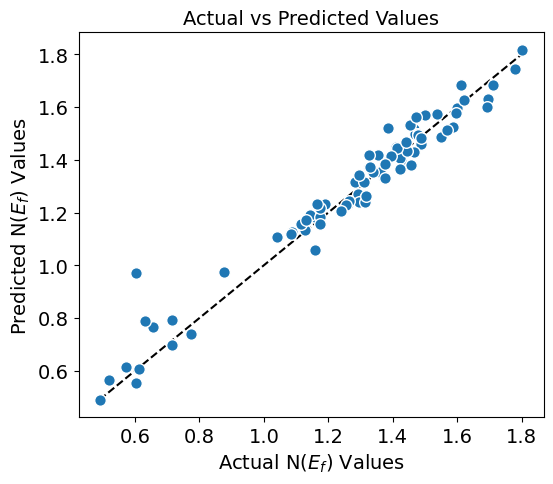

In [43]:
# predictions vs actual
import matplotlib.pyplot as plt
fs=14
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, marker='o', c= 'tab:blue', s=70, edgecolor='w')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', zorder=0)
plt.xlabel('Actual N($E_f$) Values', fontsize=fs)
plt.ylabel('Predicted N($E_f$) Values', fontsize=fs)
plt.title('Actual vs Predicted Values', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.show()

## Feature Importance using a SHAP (SHapley Additive exPlanations) Summary Plot 

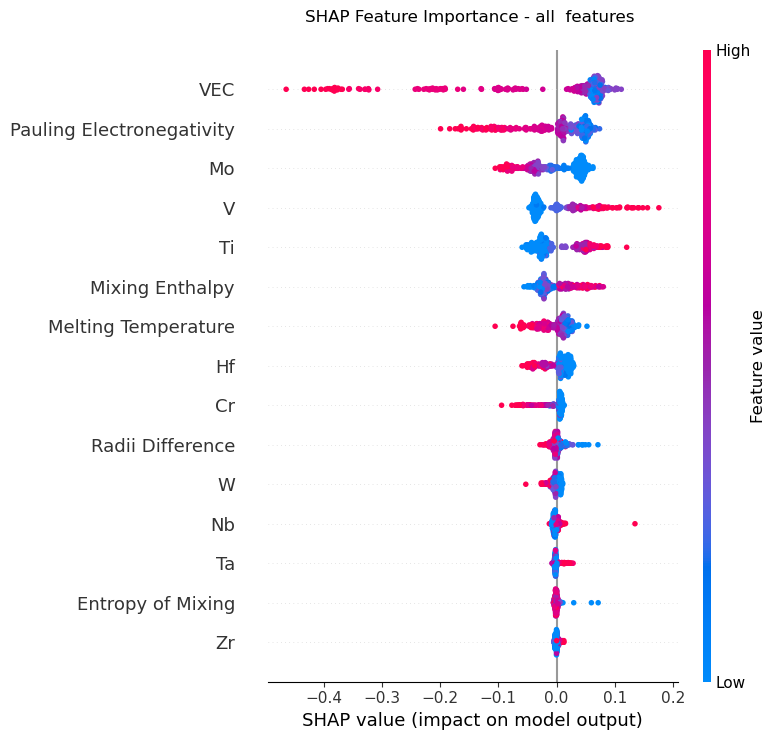

In [44]:
import shap

# Use TreeExplainer for tree-based models like Gradient Boosting
explainer = shap.Explainer(best_model, X_train)

# Compute SHAP values
shap_values = explainer(X_train)

plt.title("SHAP Feature Importance - all  features ", pad=20)

# Summary plot
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)


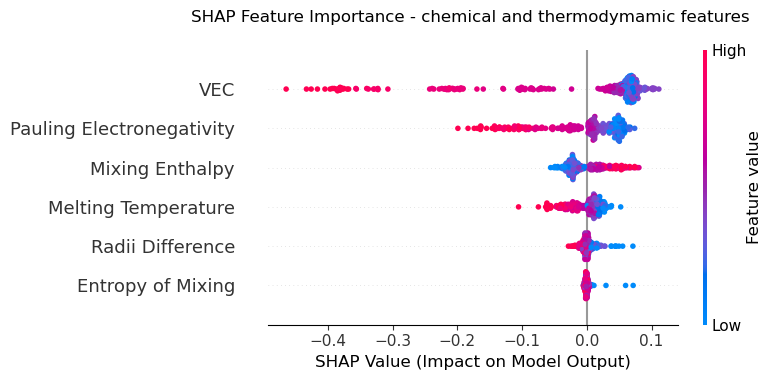

In [45]:

# Define the selected chemical and thermodynamic features
selected_features = ['Mixing Enthalpy', 'VEC', 'Melting Temperature','Radii Difference',
                    'Pauling Electronegativity', 'Entropy of Mixing']

# Create background distribution
background = shap.utils.sample(X_train, 100)  # Use 100 representative samples

# Initialize explainer with the background
explainer = shap.Explainer(best_model, background)

# Calculate SHAP values
shap_values = explainer(X_train)

# Filter for selected features
feature_indices = [X_train.columns.get_loc(f) for f in selected_features]
shap_values_selected = shap_values[:, feature_indices]

# Create enhanced summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values.values[:, feature_indices],  # Access the values array directly
    features=X_train[selected_features],
    feature_names=selected_features,
    plot_type="dot",
    show=False
)
plt.title("SHAP Feature Importance - chemical and thermodymamic features ", pad=20)
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
plt.gcf().tight_layout()
plt.show()



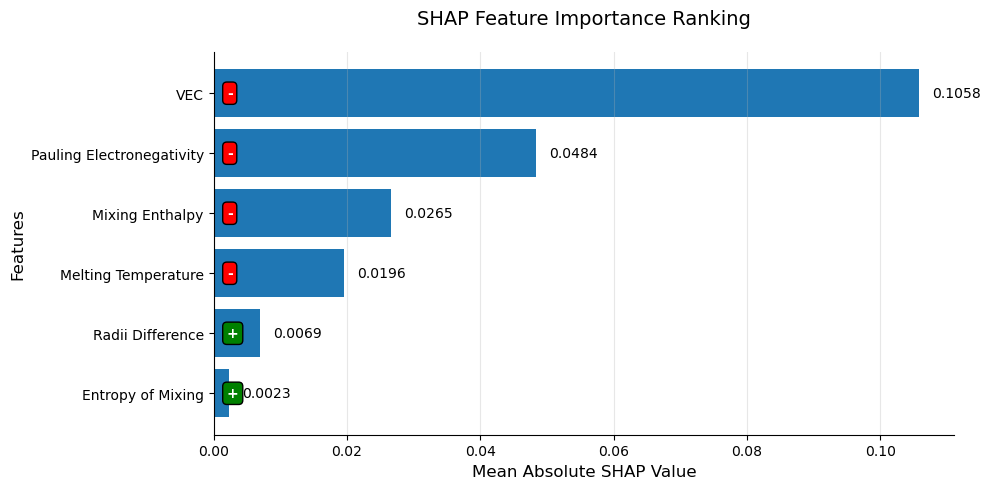

In [46]:

# Get SHAP importance values 
shap_values_array = shap_values.values[:, feature_indices]
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

# Sort features by importance
sorted_idx = np.argsort(mean_abs_shap)
sorted_features = np.array(selected_features)[sorted_idx]
sorted_importance = mean_abs_shap[sorted_idx]

# Create the plot
plt.figure(figsize=(10, 5))
bars = plt.barh(sorted_features, sorted_importance, color='#1f77b4')

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.002, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}',
             ha='left', va='center')

# Add directional markers
for i, (feature, importance) in enumerate(zip(sorted_features, mean_abs_shap[sorted_idx])):
    direction = '+' if np.mean(shap_values_array[:, sorted_idx[i]]) > 0 else '-'
    plt.text(0.002, i, direction, 
             ha='left', va='center', 
             color='white', weight='bold',
             bbox=dict(facecolor='green' if direction == '+' else 'red', 
                      boxstyle='round,pad=0.3'))

# Formatting
plt.xlabel('Mean Absolute SHAP Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('SHAP Feature Importance Ranking', fontsize=14, pad=20)
plt.grid(axis='x', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

plt.show()

# Save the model

In [47]:
# Save the model
joblib.dump(best_model, 'GB_final_model.pkl')

['GB_final_model.pkl']